# AutoML: Train "the best" Image Classification Multi-Label model for a 'Fridge items' dataset.

# 1. Connect to Azure Machine Learning Workspace

## 1.1. Import the required libraries

In [1]:
# Import required libraries
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient

from azure.ai.ml.automl import SearchSpace, ClassificationMultilabelPrimaryMetrics
from azure.ai.ml.sweep import (
    Choice,
    Uniform,
    BanditPolicy,
)

from azure.ai.ml import automl

## 1.2. Configure workspace details and get a handle to the workspace

In [2]:
credential = DefaultAzureCredential()
ml_client = None
try:
    ml_client = MLClient.from_config(credential)
except Exception as ex:
    print(ex)
    # Enter details of your AML workspace
    subscription_id = "95f0f8ca-f707-440a-a9a1-e107df0635dd"
    resource_group = "master_thesis"
    workspace = "master"
    ml_client = MLClient(credential, subscription_id, resource_group, workspace)

We could not find config.json in: . or in its parent directories. Please provide the full path to the config file or ensure that config.json exists in the parent directories.


Class WorkspaceHubOperations: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


# 2. MLTable with input Training Data

## 2.1. Download the Data

In [3]:
import os
import urllib
from zipfile import ZipFile

# Change to a different location if you prefer
dataset_parent_dir = './'

# create data folder if it doesnt exist.
os.makedirs(dataset_parent_dir, exist_ok=True)

dataset_name = 'assets'

# Get dataset path for later use
dataset_dir = os.path.join(dataset_parent_dir, dataset_name)


This is a sample image from this dataset:

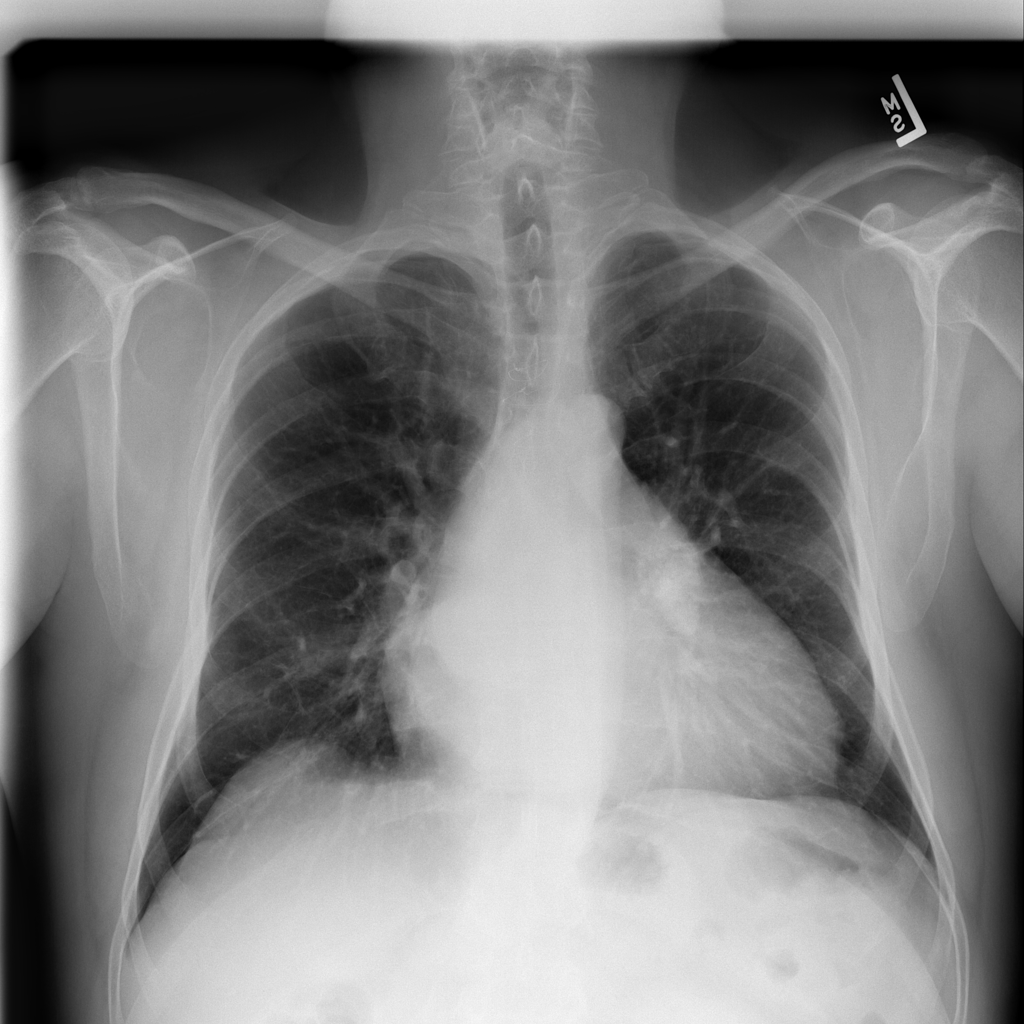

In [4]:
from IPython.display import Image

sample_image = os.path.join(dataset_dir, "images", "00000001_001.png")
Image(filename=sample_image)

## 2.2. Upload the images to Datastore through an AML Data asset (URI Folder)

In [5]:
# Uploading image files by creating a 'data asset URI FOLDER':

from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml import Input

my_data = Data(
    path=dataset_dir,
    type=AssetTypes.URI_FOLDER,
    description="images multilabel",
    name="images-multilabel",
)

uri_folder_data_asset = ml_client.data.create_or_update(my_data)

print(uri_folder_data_asset)
print("")
print("Path to folder in Blob Storage:")
print(uri_folder_data_asset.path)

Your file exceeds 100 MB. If you experience low speeds, latency, or broken connections, we recommend using the AzCopyv10 tool for this file transfer.

Example: azcopy copy '/Users/olga/Desktop/Master_Thesis/multilabel_with_normal_and_one_disease/assets' 'https://master1616554983.blob.core.windows.net/azureml-blobstore-09c827ea-90f2-4941-957e-6a0dba83d6eb/LocalUpload/d6c6d88eb3a211ea9b6648367b579f0f/assets' 

See https://docs.microsoft.com/azure/storage/common/storage-use-azcopy-v10 for more information.
Uploading assets (5764.69 MBs): 100%|█| 5764686428/5764686428 [10:11<00:00, 9425




creation_context:
  created_at: '2024-06-11T16:38:25.002348+00:00'
  created_by: Olga Petan
  created_by_type: User
  last_modified_at: '2024-06-11T16:38:25.013443+00:00'
description: images multilabel
id: /subscriptions/95f0f8ca-f707-440a-a9a1-e107df0635dd/resourceGroups/master_thesis/providers/Microsoft.MachineLearningServices/workspaces/master/data/images-multilabel/versions/7
name: images-multilabel
path: azureml://subscriptions/95f0f8ca-f707-440a-a9a1-e107df0635dd/resourcegroups/master_thesis/workspaces/master/datastores/workspaceblobstore/paths/LocalUpload/d6c6d88eb3a211ea9b6648367b579f0f/assets/
properties: {}
tags: {}
type: uri_folder
version: '7'


Path to folder in Blob Storage:
azureml://subscriptions/95f0f8ca-f707-440a-a9a1-e107df0635dd/resourcegroups/master_thesis/workspaces/master/datastores/workspaceblobstore/paths/LocalUpload/d6c6d88eb3a211ea9b6648367b579f0f/assets/


## 2.3. Convert the downloaded data to JSONL

In [6]:
import json

# ------Start Class ------#
class JSONLConverter:
    """
    Base class for JSONL converters
    ...
    Attributes
    ---------
    base_url : str
        the base for the image_url to be written into the jsonl file
    """

    def __init__(self, base_url):
        self.jsonl_data = []
        self.base_url = base_url

    def convert(self):
        raise NotImplementedError


# ------End Class------#


def write_json_lines(converter, filename):
    """
    Converts and writes a jsonl file

    Parameters:
        converter (JSONLConverter): the converter use to generate the jsonl
        filename (str): output file for writing jsonl
        base_url (str): the base for the image_url to be written into the jsonl file
    """
    json_lines_data = converter.convert()
    with open(filename, "w") as outfile:
        for json_line in json_lines_data:
            json.dump(json_line, outfile, separators=(",", ":"))
            outfile.write("\n")
        print(f"Conversion completed. Converted {len(json_lines_data)} lines.")

In [7]:
class ClassificationJSONLConverter(JSONLConverter):
    """
    Class for converting classification data into jsonl files
    ...
    Attributes
    ---------
    base_url : str
        the base for the image_url to be written into the jsonl file
    data_dir : directory containing image data for multiclass classification
    label_file: file containing annotations for multilabel classification
    """

    def __init__(self, base_url, data_dir=None, label_file=None):
        self.label_file = label_file
        self.data_dir = data_dir
        super().__init__(base_url)

    def convert(self):
        """
        Generate jsonl data for multilabel or multiclass classification

        return: list of lines for jsonl
        rtype: List <class 'dict'>

        """
        if self.label_file is not None:  # multilabel classification
            return self.multilabel2jsonl()
        elif self.data_dir is not None:  # multiclass classification
            return self.multiclass2jsonl()
        else:
            return None

    def multiclass2jsonl(self):
        """
        Generate jsonl data for multiclass classification

        return: list of lines for jsonl
        rtype: List <class 'dict'>

        """
        # Baseline of json line dictionary
        json_line_sample = {
            "image_url": self.base_url,
            "label": "",
        }
        index = 0
        # Scan each sub directary and generate a jsonl line per image, distributed on train and valid JSONL files
        for class_name in os.listdir(self.data_dir):
            sub_dir = os.path.join(self.data_dir, class_name)
            if not os.path.isdir(sub_dir):
                continue

            # Scan each sub directary
            print(f"Parsing {sub_dir}")
            for image in os.listdir(sub_dir):
                json_line = dict(json_line_sample)
                json_line["image_url"] += f"{class_name}/{image}"
                json_line["label"] = class_name

                self.jsonl_data.append(json_line)
                index += 1

        return self.jsonl_data

    def multilabel2jsonl(self):
        """
        Generate jsonl data for multilabel classification

        return: list of lines for jsonl
        rtype: List <class 'dict'>

        """
        # Baseline of json line dictionary
        json_line_sample = {
            "image_url": self.base_url,
            "label": [],
        }

        # Read each annotation and convert it to jsonl line
        with open(self.label_file, "r") as labels:
            for i, line in enumerate(labels):
                # Skipping the title line and any empty lines.
                if i == 0 or len(line.strip()) == 0:
                    continue
                line_split = line.strip().split(",")
                if len(line_split) != 2:
                    print(f"Skipping the invalid line: {line}")
                    continue
                json_line = dict(json_line_sample)
                json_line["image_url"] += f"images/{line_split[0]}"
                json_line["label"] = line_split[1].strip().split(" ")

                self.jsonl_data.append(json_line)

        return self.jsonl_data

## First generate the jsonl file

In [8]:
import sys

sys.path.insert(0, "../jsonl-conversion/")

converter = ClassificationJSONLConverter(
    uri_folder_data_asset.path, label_file=os.path.join(dataset_dir, "labels.csv")
)
jsonl_annotations = os.path.join(dataset_dir, "annotations.jsonl")
write_json_lines(converter, jsonl_annotations)

Conversion completed. Converted 14401 lines.


## Then split the data into train and validation

In [9]:
import json
import os

# We'll copy each JSONL file within its related MLTable folder
training_mltable_path = os.path.join(dataset_parent_dir, "training-mltable-folder")
validation_mltable_path = os.path.join(dataset_parent_dir, "validation-mltable-folder")

# First, let's create the folders if they don't exist
os.makedirs(training_mltable_path, exist_ok=True)
os.makedirs(validation_mltable_path, exist_ok=True)

train_validation_ratio = 5

# Path to the training and validation files
train_annotations_file = os.path.join(training_mltable_path, "train_annotations.jsonl")
validation_annotations_file = os.path.join(
    validation_mltable_path, "validation_annotations.jsonl"
)

with open(jsonl_annotations, "r") as annot_f:
    json_lines = annot_f.readlines()

index = 0
with open(train_annotations_file, "w") as train_f:
    with open(validation_annotations_file, "w") as validation_f:
        for json_line in json_lines:
            if index % train_validation_ratio == 0:
                # validation annotation
                validation_f.write(json_line)
            else:
                # train annotation
                train_f.write(json_line)
            index += 1

## 2.4. Create MLTable data input

In [10]:
def create_ml_table_file(filename):
    """Create ML Table definition"""

    return (
        "paths:\n"
        "  - file: ./{0}\n"
        "transformations:\n"
        "  - read_json_lines:\n"
        "        encoding: utf8\n"
        "        invalid_lines: error\n"
        "        include_path_column: false\n"
        "  - convert_column_types:\n"
        "      - columns: image_url\n"
        "        column_type: stream_info"
    ).format(filename)


def save_ml_table_file(output_path, mltable_file_contents):
    with open(os.path.join(output_path, "MLTable"), "w") as f:
        f.write(mltable_file_contents)


# Create and save train mltable
train_mltable_file_contents = create_ml_table_file(
    os.path.basename(train_annotations_file)
)
save_ml_table_file(training_mltable_path, train_mltable_file_contents)

# Save train and validation mltable
validation_mltable_file_contents = create_ml_table_file(
    os.path.basename(validation_annotations_file)
)
save_ml_table_file(validation_mltable_path, validation_mltable_file_contents)

In [11]:
# Training MLTable defined locally, with local data to be uploaded
my_training_data_input = Input(type=AssetTypes.MLTABLE, path=training_mltable_path)

# Validation MLTable defined locally, with local data to be uploaded
my_validation_data_input = Input(type=AssetTypes.MLTABLE, path=validation_mltable_path)

# WITH REMOTE PATH: If available already in the cloud/workspace-blob-store
# my_training_data_input = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/train")
# my_validation_data_input = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/valid")

# 3. Compute target setup

In [12]:
from azure.ai.ml.entities import AmlCompute
from azure.core.exceptions import ResourceNotFoundError

compute_name = "masterthesis2"

try:
    _ = ml_client.compute.get(compute_name)
    print("Found existing compute target.")
except ResourceNotFoundError:
    print("Creating a new compute target...")
    compute_config = AmlCompute(
        name=compute_name,
        type="amlcompute",
        size="Standard_NC6s_v3",
        idle_time_before_scale_down=120,
        min_instances=0,
        max_instances=4,
    )
    ml_client.begin_create_or_update(compute_config).result()

Found existing compute target.


# 4. Configure and run the AutoML for Images Classification-Multilabel training job

In [13]:
# general job parameters
exp_name = "multilabel_classification"

## 4.3. Manual hyperparameter sweeping for your model

In [100]:
# Create the AutoML job with the related factory-function.

image_classification_multilabel_job = automl.image_classification_multilabel(
    compute=compute_name,
    name="multilabel_classification_20",
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
    primary_metric=ClassificationMultilabelPrimaryMetrics.IOU,
)

image_classification_multilabel_job.set_training_parameters(
    advanced_settings='{"apply_automl_train_augmentations": true}'
)

image_classification_multilabel_job.set_limits(
    timeout_minutes=120,
    max_trials=15,
    max_concurrent_trials=3,
)

image_classification_multilabel_job.extend_search_space(
    [
        SearchSpace(
            model_name=Choice(["seresnext", "resnet50", "vitb16r224", "resnest101"]),
            learning_rate=Uniform(0.0001, 0.001),
            number_of_epochs=Choice([20, 30, 50]),
            gradient_accumulation_step=Choice([1]),
            validation_resize_size=Choice([288, 320, 352]),
            validation_crop_size=Choice([224, 256]),  # model-specific
            training_crop_size=Choice([224, 256]),
            optimizer=Choice(['adam', 'sgd']),
            training_batch_size=Choice([40, 50, 60]),
        ),
    ]
)

image_classification_multilabel_job.set_sweep(
    sampling_algorithm="Random",
    early_termination=BanditPolicy(
        evaluation_interval=2, slack_factor=0.2, delay_evaluation=6
    ),
)

In [101]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    image_classification_multilabel_job
)  # submit the job to the backend

print(f"Created job: {returned_job}")

Created job: compute: azureml:masterthesis2
creation_context:
  created_at: '2024-06-16T11:08:27.328242+00:00'
  created_by: Olga Petan
  created_by_type: User
display_name: multilabel_classification_20
experiment_name: multilabel_classification
id: azureml:/subscriptions/95f0f8ca-f707-440a-a9a1-e107df0635dd/resourceGroups/master_thesis/providers/Microsoft.MachineLearningServices/workspaces/master/jobs/multilabel_classification_20
limits:
  max_concurrent_trials: 3
  max_trials: 15
  timeout_minutes: 120
log_verbosity: info
name: multilabel_classification_20
outputs: {}
primary_metric: iou
properties: {}
resources:
  instance_count: 1
  shm_size: 2g
search_space:
- gradient_accumulation_step:
    type: choice
    values:
    - 1
  learning_rate:
    max_value: 0.001
    min_value: 0.0001
    type: uniform
  model_name:
    type: choice
    values:
    - seresnext
    - resnet50
    - vitb16r224
    - resnest101
  number_of_epochs:
    type: choice
    values:
    - 20
    - 30
    - 50

In [102]:
ml_client.jobs.stream(returned_job.name)

RunId: multilabel_classification_20
Web View: https://ml.azure.com/runs/multilabel_classification_20?wsid=/subscriptions/95f0f8ca-f707-440a-a9a1-e107df0635dd/resourcegroups/master_thesis/workspaces/master

Execution Summary
RunId: multilabel_classification_20
Web View: https://ml.azure.com/runs/multilabel_classification_20?wsid=/subscriptions/95f0f8ca-f707-440a-a9a1-e107df0635dd/resourcegroups/master_thesis/workspaces/master



In [93]:
hd_job = ml_client.jobs.get(returned_job.name + "_HD")
hd_job

Experiment,Name,Type,Status,Details Page
binary_classificaiton_reduced,binary_classification_v2_4_HD,sweep,Completed,Link to Azure Machine Learning studio


# 5. Retrieve the Best Trial (Best Model's trial/run)

## Initialize MLFlow Client

In [94]:
#!pip install azureml_mlflow

In [95]:
#!pip install mlflow

In [96]:
import mlflow

# Obtain the tracking URL from MLClient
MLFLOW_TRACKING_URI = ml_client.workspaces.get(
    name=ml_client.workspace_name
).mlflow_tracking_uri

print(MLFLOW_TRACKING_URI)

azureml://westeurope.api.azureml.ms/mlflow/v1.0/subscriptions/95f0f8ca-f707-440a-a9a1-e107df0635dd/resourceGroups/master_thesis/providers/Microsoft.MachineLearningServices/workspaces/master


In [97]:
# Set the MLFLOW TRACKING URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(f"\nCurrent tracking uri: {mlflow.get_tracking_uri()}")


Current tracking uri: azureml://westeurope.api.azureml.ms/mlflow/v1.0/subscriptions/95f0f8ca-f707-440a-a9a1-e107df0635dd/resourceGroups/master_thesis/providers/Microsoft.MachineLearningServices/workspaces/master


In [98]:
from mlflow.tracking.client import MlflowClient

# Initialize MLFlow client
mlflow_client = MlflowClient()

### Get the AutoML parent Job

In [99]:
job_name = returned_job.name

# Example if providing an specific Job name/ID
# job_name = "salmon_camel_5sdf05xvb3"

# Get the parent run
mlflow_parent_run = mlflow_client.get_run(job_name)

print("Parent Run: ")
print(mlflow_parent_run)

Parent Run: 
<Run: data=<RunData: metrics={'AUC_macro': 0.79482,
 'AUC_micro': 0.82966,
 'AUC_weighted': 0.77535,
 'accuracy': 0.10809,
 'average_precision_score_macro': 0.45603,
 'average_precision_score_micro': 0.50055,
 'average_precision_score_weighted': 0.48358,
 'f1_score_macro': 0.38783,
 'f1_score_micro': 0.42548,
 'f1_score_weighted': 0.40788,
 'iou': 0.30207,
 'iou_macro': 0.25322,
 'iou_micro': 0.27023,
 'iou_train': 0.2386,
 'iou_weighted': 0.26603,
 'log_loss': 0.34303,
 'log_loss_train': 0.32128,
 'precision_score_macro': 0.55515,
 'precision_score_micro': 0.5838,
 'precision_score_weighted': 0.56017,
 'recall_score_macro': 0.31523,
 'recall_score_micro': 0.3347,
 'recall_score_weighted': 0.3347}, params={}, tags={'automl_best_child_run_id': 'binary_classification_v2_4_HD_4',
 'fit_time_000': 'NaN',
 'is_gpu': 'True',
 'iteration_000': '0',
 'mlflow.rootRunId': 'binary_classification_v2_4',
 'mlflow.runName': 'binary_classification_v2_4',
 'mlflow.user': 'Olga Petan',
 'm

In [100]:
# Print parent run tags. 'automl_best_child_run_id' tag should be there.
print(mlflow_parent_run.data.tags.keys())

dict_keys(['model_explain_run', 'is_gpu', 'pipeline_id_000', 'score_000', 'predicted_cost_000', 'fit_time_000', 'training_percent_000', 'iteration_000', 'run_preprocessor_000', 'run_algorithm_000', 'automl_best_child_run_id', 'mlflow.rootRunId', 'mlflow.runName', 'mlflow.user'])


### Get the AutoML best child run

In [101]:
# Get the best model's child run
best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print(f"Found best child run id: {best_child_run_id}")

best_run = mlflow_client.get_run(best_child_run_id)

print("Best child run: ")
print(best_run)

Found best child run id: binary_classification_v2_4_HD_4
Best child run: 
<Run: data=<RunData: metrics={'AUC_macro': 0.79482,
 'AUC_micro': 0.82966,
 'AUC_weighted': 0.77535,
 'accuracy': 0.10809,
 'average_precision_score_macro': 0.45603,
 'average_precision_score_micro': 0.50055,
 'average_precision_score_weighted': 0.48358,
 'f1_score_macro': 0.38783,
 'f1_score_micro': 0.42548,
 'f1_score_weighted': 0.40788,
 'iou': 0.30207,
 'iou_macro': 0.25322,
 'iou_micro': 0.27023,
 'iou_train': 0.2386,
 'iou_weighted': 0.26603,
 'log_loss': 0.34303,
 'log_loss_train': 0.32128,
 'precision_score_macro': 0.55515,
 'precision_score_micro': 0.5838,
 'precision_score_weighted': 0.56017,
 'recall_score_macro': 0.31523,
 'recall_score_micro': 0.3347,
 'recall_score_weighted': 0.3347}, params={}, tags={'hyperparameters': '{"model": {"learning_rate": 0.09527871893320976, '
                    '"model_name": "mobilenetv2", "optimizer": "sgd", '
                    '"train_crop_size": 256, "training_bat

## Get best model run's metrics
Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run.

In [102]:
import pandas as pd

pd.DataFrame(best_run.data.metrics, index=[0]).T

,0
iou_train,0.23860
log_loss_train,0.32128
log_loss,0.34303
accuracy,0.10809
precision_score_micro,0.58380
AUC_weighted,0.77535
average_precision_score_macro,0.45603
AUC_micro,0.82966
precision_score_weighted,0.56017
f1_score_micro,0.42548


## Download the best model locally
Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run.

In [103]:
# Create local folder
import os

local_dir = "./artifact_downloads_v2_second_run"
if not os.path.exists(local_dir):
    os.mkdir(local_dir)

In [104]:
# Download run's artifacts/outputs
local_path = mlflow_client.download_artifacts(
    best_run.info.run_id, "outputs", local_dir
)
print(f"Artifacts downloaded in: {local_path}")
print(f"Artifacts: {os.listdir(local_path)}")

2023/11/16 21:30:09 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


Artifacts downloaded in: /Users/olga/Desktop/Master_Thesis/multilabel_with_normal_and_one_disease/artifact_downloads_v2_second_run/outputs
Artifacts: ['model.pt', 'run_id.txt', 'scoring_file_v_1_0_0.py', 'mlflow-model', 'generated_code', 'conda_env_v_1_0_0.yml']


In [105]:
import os

mlflow_model_dir = os.path.join(local_dir, "outputs", "mlflow-model")

# Show the contents of the MLFlow model folder
os.listdir(mlflow_model_dir)

# You should see a list of files such as the following:
# ['artifacts', 'conda.yaml', 'MLmodel', 'python_env.yaml', 'python_model.pkl', 'requirements.txt']

['artifacts',
 'python_env.yaml',
 'requirements.txt',
 'MLmodel',
 'python_model.pkl',
 'conda.yaml']